In [1]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from emnist import extract_training_samples, list_datasets, extract_test_samples

import matplotlib.pyplot as plt

2024-03-03 11:52:54.616815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
# Download the training data from EMNIST
(train_images, train_labels) = extract_training_samples("letters")
(test_images, test_labels) = extract_test_samples("letters")

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((124800, 28, 28), (124800,), (20800, 28, 28), (20800,))

In [31]:
# Let's see the shape of an image:
train_images[327].shape

(28, 28)

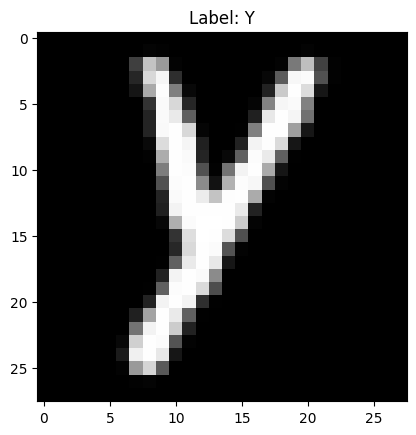

In [32]:
# Now let's plot the 327th sample to see what the raw image look like
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

plt.plot()
plt.title(f"Label: {alphabet[train_labels[327] - 1]}")
plt.imshow((train_images[327]), cmap=plt.get_cmap('gray'))
plt.show()

In [33]:
# Let's verify it matches the 327th label!
train_labels[327]

25

In [34]:
# Pixel values are black & white, and between 0 and 255
train_images.min(), train_images.max()

(0, 255)

In [35]:
# Let's normalize their values to be between 0 and 1
train_images, test_images = train_images / 255, test_images / 255
# Checking normalization: we should be between 0 and 1
train_images.min(), train_images.max()

(0.0, 1.0)

In [36]:
train_n = train_images.shape[0]
test_n = test_images.shape[0]
train_n, test_n

(124800, 20800)

In [37]:
train_images = train_images.reshape((train_n, 28, 28, 1))
test_images = test_images.reshape((test_n, 28, 28, 1))
train_images.shape, test_images.shape

((124800, 28, 28, 1), (20800, 28, 28, 1))

In [38]:
# Let's find unique values in the labels
import numpy as np

values, counts = np.unique(train_labels, return_counts=True)
nb_values = len(values)
nb_values, values, counts

(26,
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=uint8),
 array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800,
        4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800,
        4800, 4800, 4800, 4800]))

In [39]:
# One-hot encoding of the labels (5 -> [0, 0, 0, 0, 0, 1, ...])
# cf. https://en.wikipedia.org/wiki/One-hot
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [40]:
# Let's verify that labels are the proper shape: a list of list
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [41]:
train_labels.shape

(124800, 27)

In [42]:
def define_conv_model(conv_size=32):
    model = models.Sequential()

    model.add(layers.Conv2D(conv_size, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(conv_size * 2, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(conv_size * 4, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
       
    model.add(layers.Flatten())
    model.add(layers.Dense(nb_values + 1, activation='softmax'))

    return model

In [43]:
# Notes:
#   - the 'sparse_categorical_crossentropy' loss is only for labels using integers, not for encoded labels like ours
#   - we specify the optimizer instead of 'adam' to be able to change the learning rate
#   - no need to return anything, the model is modified "in-place" 
def compile_model(model, learning_rate=0.003):
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# We parameterize the training so that parameters can be logged in MLFlow
def train_model(model, train_images, train_labels, epochs=3, batch_size=64, validation_split=0.2):
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

In [45]:
import mlflow
import os

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Brief 13 - 2. EMNIST")

<Experiment: artifact_location='mlflow-artifacts:/247891186675966319', creation_time=1709463136235, experiment_id='247891186675966319', last_update_time=1709463136235, lifecycle_stage='active', name='Brief 13 - 2. EMNIST', tags={}>

In [46]:
import time

with mlflow.start_run() as parent_run:
    conv_size = 16
    learning_rate = 0.004
    epochs = 3
    batch_size = 64

    mlflow.log_param("conv_size", conv_size)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    
    model = define_conv_model(conv_size)
    compile_model(model, learning_rate)
    
    # We time only time the training part
    start_t = time.time()    
    train_model(model, train_images, train_labels, epochs, batch_size)
    end_t = time.time()

    # Evaluate the model on the test set
    loss, acc = model.evaluate(test_images, test_labels)
    print(f'Loss: {loss}, accuracy: {acc}')
    
    mlflow.log_metric("loss", loss)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("training_duration", end_t - start_t)  

    mlflow.end_run()

26
Epoch 1/3
1560/1560 [==============================] - 32s 20ms/step - loss: 0.6303 - accuracy: 0.7990 - val_loss: 0.3947 - val_accuracy: 0.8714
Epoch 2/3
1560/1560 [==============================] - 32s 20ms/step - loss: 0.4153 - accuracy: 0.8632 - val_loss: 0.3658 - val_accuracy: 0.8849
Epoch 3/3
650/650 [==============================] - 5s 7ms/step - loss: 0.3216 - accuracy: 0.8919
Loss: 0.32157889008522034, accuracy: 0.8918750286102295


In [ ]:
model.summary()